<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
## <font color='blue'>Data Science Para Análise Multivariada de Dados</font>
## <font color='blue'>Projeto 2 - Parte 2 - Modelagem</font>
### <font color='blue'>Seleção de Modelos de Machine Learning em Análise Multivariada com Dados Anonimizados</font>

### Instalando e Carregando Pacotes

In [1]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [2]:
# Este pacote não vem com o Anaconda e precisa ser instalado
# Kaggle
!pip install -q xgboost

In [3]:
# Imports
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" 

Author: Data Science Academy



## Carregando os Dados Pré-Processados

In [5]:
# Carregando o dataset de treino
df_treino = pd.read_csv('dados/dados_treino.csv')

# Carregando o dataset de treino final
df_treino_final = pd.read_csv('dados/dados_treino_final.csv')

# Carregando o dataset de validação
df_valid = pd.read_csv('dados/dados_valid.csv')

# Carregando o dataset de teste
df_teste = pd.read_csv('dados/dados_teste.csv')

In [6]:
# Carregando os nomes das colunas de entrada
with open('dados/colunas_entrada.sav', 'rb') as file:
    colunas_entrada = pickle.load(file)

## Preparando as Matrizes

In [7]:
# Prepara a Matriz X
X_treino = df_treino_final[colunas_entrada].values
X_valid = df_valid[colunas_entrada].values
X_teste = df_teste[colunas_entrada].values

In [8]:
# Prepara a Matriz Y
y_treino = df_treino_final['LABEL_TARGET'].values
y_valid = df_valid['LABEL_TARGET'].values
y_teste = df_teste['LABEL_TARGET'].values

In [9]:
# Print
print('Shape dos dados de treino:', X_treino.shape, y_treino.shape)
print('Shape dos dados de validação:', X_valid.shape, y_valid.shape)
print('Shape dos dados de teste:', X_teste.shape, y_teste.shape)

Shape dos dados de treino: (3238, 178) (3238,)
Shape dos dados de validação: (1725, 178) (1725,)
Shape dos dados de teste: (1725, 178) (1725,)


In [10]:
type(X_treino)

numpy.ndarray

In [11]:
X_treino

array([[   4,  -20,  -44, ...,  238,  206,  170],
       [-113,  -80,  -40, ..., -367, -349, -338],
       [ -41,  -26,  -18, ..., -105, -105,  -87],
       ...,
       [-122, -131, -124, ...,  -57,  -31,   -1],
       [ -67,  -79,  -85, ...,   11,   19,   12],
       [ 103,   94,   75, ...,  -56,  -81, -104]])

## Padronização dos Dados

In [12]:
# Crio o objeto
scaler = StandardScaler()

# Faço o fit
scaler.fit(X_treino)

# Salva o objeto em disco e carrega para usarmos adiante
scalerfile = 'dados/scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

# Carrega o scaler (padronizador)
scaler = pickle.load(open(scalerfile, 'rb'))

# Aplica a padronização em nossas matrizes de dados
X_treino_tf = scaler.transform(X_treino)
X_valid_tf = scaler.transform(X_valid)

In [13]:
X_treino_tf

array([[ 0.07822634, -0.03338141, -0.14620281, ...,  1.03909618,
         0.9152853 ,  0.76259816],
       [-0.4023194 , -0.27723708, -0.12986273, ..., -1.42624329,
        -1.36907003, -1.31947084],
       [-0.10659895, -0.05776698, -0.03999231, ..., -0.35860867,
        -0.36477688, -0.29073202],
       ...,
       [-0.43928446, -0.48451439, -0.47300433, ..., -0.16301149,
        -0.06019617,  0.06174423],
       [-0.21338689, -0.27317281, -0.31368859, ...,  0.11408451,
         0.14560161,  0.11502552],
       [ 0.48484197,  0.42994434,  0.33991446, ..., -0.15893655,
        -0.26599395, -0.36040756]])

## Modelagem Preditiva

### Funções Auxiliares

In [14]:
# Função para calcular a especificidade
def dsa_calcula_especificidade(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)

A especificidade é uma métrica usada para avaliar o desempenho de um modelo de classificação, especialmente em problemas de classificação binária. Ela mede a proporção de verdadeiros negativos (TN) em relação ao total de negativos reais, ou seja, a capacidade do modelo de identificar corretamente as instâncias negativas.

Aqui está o que cada parte significa:

**y_pred < thresh**: Esta é uma condição que verifica se a previsão do modelo (y_pred) é menor que um determinado limiar (thresh). Se o modelo for de classificação binária, esse limiar geralmente é 0.5, mas pode ser ajustado de acordo com as necessidades específicas do problema. Essa condição retorna um vetor booleano, onde cada elemento é True se a previsão for menor que o limiar (indicando uma previsão de classe negativa) e False caso contrário.

**y_actual == 0**: Esta é uma condição que verifica quais elementos do vetor de rótulos reais (y_actual) são iguais a 0, ou seja, pertencem à classe negativa. Isso também retorna um vetor booleano.

**(y_pred < thresh) & (y_actual == 0)**: Este é o operador lógico "e" aplicado entre os dois vetores booleanos anteriores. Ele retorna um novo vetor booleano, onde cada elemento é True apenas se ambas as condições forem verdadeiras para esse elemento, ou seja, se a previsão for negativa e o rótulo real também for negativo. Isso representa os verdadeiros negativos (TN).

**sum((y_pred < thresh) & (y_actual == 0))**: Esta é a soma dos valores True no vetor booleano resultante, que é equivalente ao número de verdadeiros negativos (TN).

**sum(y_actual == 0)**: Esta é a soma dos valores True no vetor booleano que representa os rótulos reais negativos, que é equivalente ao número total de instâncias negativas reais (TN + FP).

**sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)**: Esta é a razão entre o número de verdadeiros negativos (TN) e o número total de instâncias negativas reais (TN + FP), que é a definição de especificidade.

In [15]:
# Função para gerar relatório de métricas
def dsa_print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = dsa_calcula_especificidade(y_actual, y_pred, thresh)
    
    print('AUC:%.3f'%auc)
    print('Acurácia:%.3f'%accuracy)
    print('Recall:%.3f'%recall)
    print('Precisão:%.3f'%precision)
    print('Especificidade:%.3f'%specificity)
    print(' ')
    
    return auc, accuracy, recall, precision, specificity 

In [16]:
thresh = 0.5

### Versão 1 do Modelo - Regressão Logística (Sem Otimização de Hiperparâmetros)

Veja a descrição deste modelo no videobook.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [17]:
# Construção do modelo

# Cria o classificador (objeto)
lr1 = LogisticRegression()

# Treina e cria o modelo
modelo_v1 = lr1.fit(X_treino_tf, y_treino)

# Previsões 
y_train_preds = modelo_v1.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v1.predict_proba(X_valid_tf)[:,1]

print('Modelo de Regressão Logística (Sem Otimização de Hiperparâmetros)\n')

print('Treinamento:\n')
lr1_train_auc, lr1_train_accuracy, lr1_train_recall, lr1_train_precision, lr1_train_specificity = dsa_print_report(y_treino, 
                                                                                                                   y_train_preds, 
                                                                                                                   thresh)

print('Validação:\n')
lr1_valid_auc, lr1_valid_accuracy, lr1_valid_recall, lr1_valid_precision, lr1_valid_specificity = dsa_print_report(y_valid, 
                                                                                                                   y_valid_preds, 
                                                                                                                   thresh)


Modelo de Regressão Logística (Sem Otimização de Hiperparâmetros)

Treinamento:

AUC:0.623
Acurácia:0.644
Recall:0.532
Precisão:0.685
Especificidade:0.755
 
Validação:

AUC:0.508
Acurácia:0.668
Recall:0.434
Precisão:0.282
Especificidade:0.726
 


### Versão 2 do Modelo - Regressão Logística (Com Otimização de Hiperparâmetros)

Veja a descrição deste modelo no videobook.

In [18]:
# Construção do modelo

# Cria o classificador (objeto)
lr2 = LogisticRegression(random_state = 142, solver = 'liblinear')

# Treina e cria o modelo
modelo_v2 = lr2.fit(X_treino_tf, y_treino)

# Previsões 
y_train_preds = modelo_v2.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v2.predict_proba(X_valid_tf)[:,1]

print('Modelo de Regressão Logística (Com Otimização de Hiperparâmetros)\n')

print('Treinamento:\n')
lr2_train_auc, lr2_train_accuracy, lr2_train_recall, lr2_train_precision, lr2_train_specificity = dsa_print_report(y_treino, 
                                                                                                                   y_train_preds, 
                                                                                                                   thresh)

print('Validação:\n')
lr2_valid_auc, lr2_valid_accuracy, lr2_valid_recall, lr2_valid_precision, lr2_valid_specificity = dsa_print_report(y_valid, 
                                                                                                                   y_valid_preds, 
                                                                                                                   thresh)


Modelo de Regressão Logística (Com Otimização de Hiperparâmetros)

Treinamento:

AUC:0.625
Acurácia:0.644
Recall:0.531
Precisão:0.687
Especificidade:0.758
 
Validação:

AUC:0.511
Acurácia:0.670
Recall:0.429
Precisão:0.282
Especificidade:0.729
 


### Versão 3 do Modelo - Naive Bayes

Veja a descrição deste modelo no videobook.

https://scikit-learn.org/stable/modules/naive_bayes.html

In [19]:
# Construção do modelo

# Cria o classificador (objeto)
nb = GaussianNB()

# Treina e cria o modelo
modelo_v3 = nb.fit(X_treino_tf, y_treino)

# Previsões
y_train_preds = modelo_v3.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v3.predict_proba(X_valid_tf)[:,1]

print('Modelo Naive Bayes:\n')

print('Treinamento:\n')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity = dsa_print_report(y_treino, 
                                                                                                              y_train_preds, 
                                                                                                              thresh)

print('Validação:\n')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = dsa_print_report(y_valid, 
                                                                                                              y_valid_preds, 
                                                                                                              thresh)


Modelo Naive Bayes:

Treinamento:

AUC:0.984
Acurácia:0.935
Recall:0.898
Precisão:0.971
Especificidade:0.973
 
Validação:

AUC:0.986
Acurácia:0.960
Recall:0.892
Precisão:0.905
Especificidade:0.977
 


### Versão 4 do Modelo - XGBoost (Xtreme Gradient Boosting Classifier)

Veja a descrição deste modelo no videobook.

https://xgboost.readthedocs.io/en/stable/index.html

In [20]:
# Construção do modelo (Ensemble)

# Cria o classificador
xgbc = XGBClassifier()

# Treina e cria o modelo
modelo_v4 = xgbc.fit(X_treino_tf, y_treino)

# Previsões
y_train_preds = modelo_v4.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v4.predict_proba(X_valid_tf)[:,1]

print('Modelo Xtreme Gradient Boosting Classifier:\n')

print('Treinamento:\n')
xgbc_train_auc, xgbc_train_accuracy, xgbc_train_recall, xgbc_train_precision, xgbc_train_specificity = dsa_print_report(y_treino, 
                                                                                                                        y_train_preds, 
                                                                                                                        thresh)

print('Validação:\n')
xgbc_valid_auc, xgbc_valid_accuracy, xgbc_valid_recall, xgbc_valid_precision, xgbc_valid_specificity = dsa_print_report(y_valid, 
                                                                                                                        y_valid_preds, 
                                                                                                                        thresh)


Modelo Xtreme Gradient Boosting Classifier:

Treinamento:

AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 
Validação:

AUC:0.992
Acurácia:0.966
Recall:0.948
Precisão:0.890
Especificidade:0.971
 


## Versão 5 do Modelo - RandomForest

Veja a descrição deste modelo no videobook.

In [21]:
# Cria o classificador com RandomForest
rfc = RandomForestClassifier()

# Treina e cria o modelo
modelo_v5 = rfc.fit(X_treino_tf, y_treino)

# Previsões
y_train_preds = modelo_v5.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v5.predict_proba(X_valid_tf)[:,1]

print('Modelo Random Forest Classifier:\n')

print('Treinamento:\n')
rfc_train_auc, rfc_train_accuracy, rfc_train_recall, rfc_train_precision, rfc_train_specificity = dsa_print_report(y_treino, 
                                                                                                                   y_train_preds, 
                                                                                                                   thresh)

print('Validação:\n')
rfc_valid_auc, rfc_valid_accuracy, rfc_valid_recall, rfc_valid_precision, rfc_valid_specificity = dsa_print_report(y_valid, 
                                                                                                                   y_valid_preds, 
                                                                                                                   thresh)


Modelo Random Forest Classifier:

Treinamento:

AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 
Validação:

AUC:0.993
Acurácia:0.961
Recall:0.980
Precisão:0.848
Especificidade:0.952
 


### Seleção de Modelos

In [22]:
# Tabela de resultados
df_results = pd.DataFrame({'classificador':['RL1', 'RL1', 'RL2', 'RL2', 'NB', 'NB', 'XGB', 'XGB', 'RFC', 'RFC'],
                           'data_set':['treino','valid'] * 5,
                           'auc':[lr1_train_auc,
                                  lr1_valid_auc,
                                  lr2_train_auc,
                                  lr2_valid_auc,
                                  nb_train_auc,
                                  nb_valid_auc,
                                  xgbc_train_auc,
                                  xgbc_valid_auc,
                                  rfc_train_auc,
                                  rfc_valid_auc],
                           'accuracy':[lr1_train_accuracy,
                                       lr1_valid_accuracy,
                                       lr2_train_accuracy,
                                       lr2_valid_accuracy,
                                       nb_train_accuracy,
                                       nb_valid_accuracy,
                                       xgbc_train_accuracy,
                                       xgbc_valid_accuracy,
                                       rfc_train_accuracy,
                                       rfc_valid_accuracy],
                           'recall':[lr1_train_recall,
                                     lr1_valid_recall,
                                     lr2_train_recall,
                                     lr2_valid_recall,
                                     nb_train_recall,
                                     nb_valid_recall,
                                     xgbc_train_recall,
                                     xgbc_valid_recall,
                                     rfc_train_recall,
                                     rfc_valid_recall],
                           'precision':[lr1_train_precision,
                                        lr1_valid_precision,
                                        lr2_train_precision,
                                        lr2_valid_precision,
                                        nb_train_precision,
                                        nb_valid_precision,
                                        xgbc_train_precision,
                                        xgbc_valid_precision,
                                        rfc_train_precision,
                                        rfc_valid_precision],
                           'specificity':[lr1_train_specificity,
                                          lr1_valid_specificity,
                                          lr2_train_specificity,
                                          lr2_valid_specificity,
                                          nb_train_specificity,
                                          nb_valid_specificity,
                                          xgbc_train_specificity,
                                          xgbc_valid_specificity,
                                          rfc_train_specificity,
                                          rfc_valid_specificity]})

In [23]:
# Resultados
df_results

,classificador,data_set,auc,accuracy,recall,precision,specificity
0,RL1,treino,0.623185,0.643607,0.531810,0.684964,0.755405
1,RL1,valid,0.508352,0.667826,0.434402,0.282197,0.725760
2,RL2,treino,0.625061,0.644225,0.530574,0.686651,0.757875
3,RL2,valid,0.510774,0.669565,0.428571,0.282150,0.729378
4,NB,treino,0.983968,0.935454,0.898085,0.970628,0.972823
5,NB,valid,0.986101,0.960000,0.892128,0.905325,0.976845
6,XGB,treino,1.000000,1.000000,1.000000,1.000000,1.000000
7,XGB,valid,0.992178,0.966377,0.947522,0.890411,0.971056
8,RFC,treino,1.000000,1.000000,1.000000,1.000000,1.000000
9,RFC,valid,0.993392,0.961159,0.979592,0.848485,0.951520


In [24]:
# Resultados em validação com ordenação pelo AUC
df_results[df_results['data_set'] == 'valid'].sort_values(by = 'auc', ascending = False)

,classificador,data_set,auc,accuracy,recall,precision,specificity
9,RFC,valid,0.993392,0.961159,0.979592,0.848485,0.951520
7,XGB,valid,0.992178,0.966377,0.947522,0.890411,0.971056
5,NB,valid,0.986101,0.960000,0.892128,0.905325,0.976845
3,RL2,valid,0.510774,0.669565,0.428571,0.282150,0.729378
1,RL1,valid,0.508352,0.667826,0.434402,0.282197,0.725760


A métrica de desempenho escolhida será a pontuação AUC (AUC Score) do conjunto de validação. É a pontuação mais comum usada para comparar modelos de algoritmos diferentes.

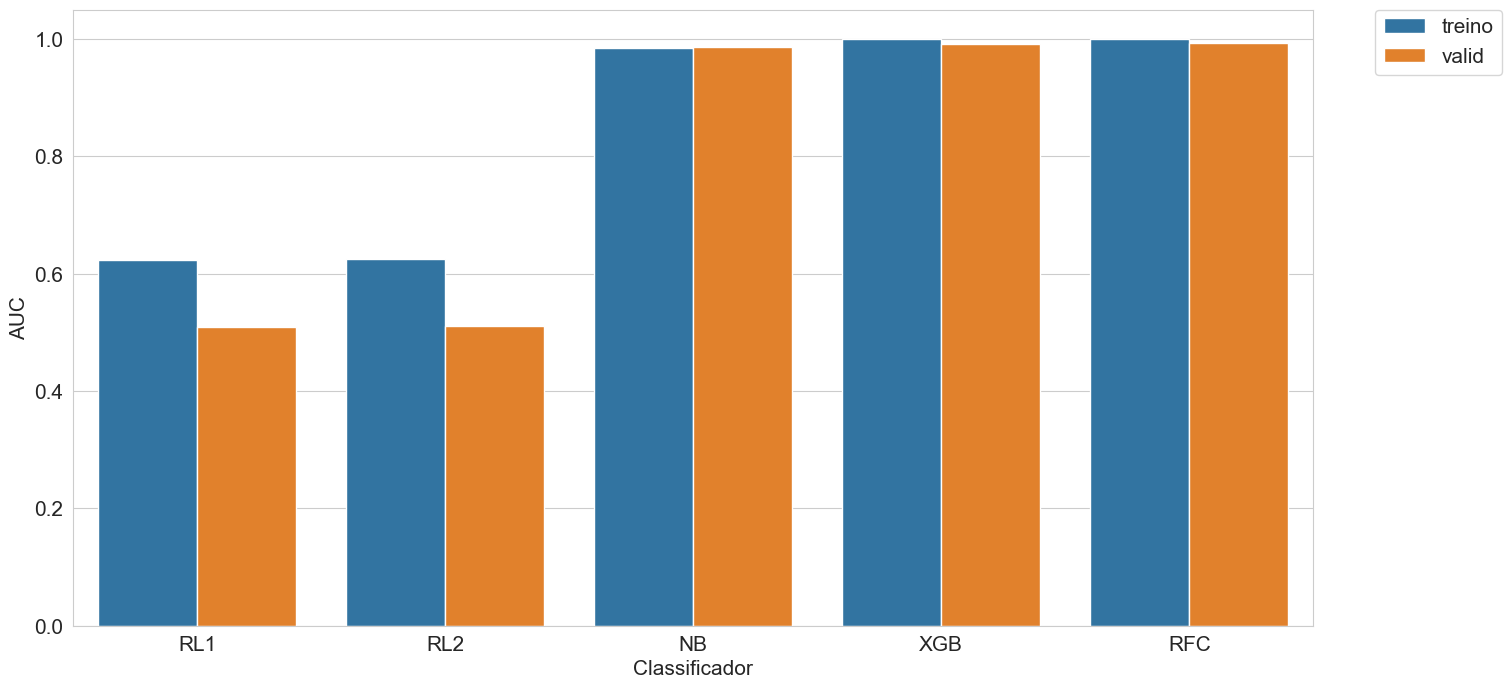

In [25]:
# Construção do Plot
sns.set_style("whitegrid")
plt.figure(figsize = (16, 8))

# Gráfico de barras
ax = sns.barplot(x = 'classificador', y = 'auc', hue = 'data_set', data = df_results)
ax.set_xlabel('Classificador', fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize = 15)

# Legenda
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., fontsize = 15)

## Otimização de Hiperparâmetros e Validação Cruzada

Será que conseguimos melhorar a performance do melhor modelo? 

Para incluir a otimização de hiperparâmetros e a validação cruzada no projeto, você pode usar o GridSearchCV do scikit-learn, que permite buscar a melhor combinação de hiperparâmetros para o modelo. Vamos usar o RandomForest como modelo base.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [26]:
%%time

# Importa a função GridSearchCV
from sklearn.model_selection import GridSearchCV

# Defina o espaço de busca dos hiperparâmetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Cria o classificador com RandomForest
classificador = RandomForestClassifier()

# Configura o GridSearchCV
grid_search = GridSearchCV(estimator = classificador, 
                           param_grid = param_grid, 
                           cv = 5, 
                           scoring = 'roc_auc', 
                           verbose = 2, 
                           n_jobs = -1)

# Treina o modelo com validação cruzada e busca pelos melhores hiperparâmetros
modelo_v5_otimizado = grid_search.fit(X_treino_tf, y_treino)

# Melhores hiperparâmetros encontrados
print('Melhores hiperparâmetros:', modelo_v5_otimizado.best_params_)

# Previsões
y_train_preds = modelo_v5_otimizado.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_v5_otimizado.predict_proba(X_valid_tf)[:,1]

print('Modelo Random Forest Classifier com Otimização de Hiperparâmetros e Validação Cruzada:\n')

print('Treinamento:\n')
rfc_train_auc, rfc_train_accuracy, rfc_train_recall, rfc_train_precision, rfc_train_specificity = dsa_print_report(y_treino, 
                                                                                                                   y_train_preds, 
                                                                                                                   thresh)

print('Validação:\n')
rfc_valid_auc, rfc_valid_accuracy, rfc_valid_recall, rfc_valid_precision, rfc_valid_specificity = dsa_print_report(y_valid, 
                                                                                                                   y_valid_preds, 
                                                                                                                   thresh)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Melhores hiperparâmetros: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Modelo Random Forest Classifier com Otimização de Hiperparâmetros e Validação Cruzada:

Treinamento:

AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 
Validação:

AUC:0.994
Acurácia:0.962
Recall:0.980
Precisão:0.853
Especificidade:0.955
 
CPU times: user 3.72 s, sys: 256 ms, total: 3.98 s
Wall time: 1min 31s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   4.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimat

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   2.9s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.8s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   4.3s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   3.9s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   3.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estim

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   4.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   4.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   4.2s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   2.6s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   2.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_est

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   4.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   4.1s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   4.0s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_est

## Qual Versão Final Devemos Usar? Justifique Sua Resposta!

Modelo RandomForest "Vanilla":

Validação:

- AUC:0.993
- Acurácia:0.958
- Recall:0.977
- Precisão:0.838
- Especificidade:0.951
 

Modelo RandomForest Otimizado:

Validação:

- AUC:0.993
- Acurácia:0.961
- Recall:0.980
- Precisão:0.846
- Especificidade:0.956

Ambos os modelos com RandomForest apresentam desempenho muito alto, mas há algumas nuances a serem consideradas ao escolher qual deles usar:

**Desempenho na validação**: O modelo com otimização de hiperparâmetros tem uma AUC ligeiramente maior na validação, o que indica que ele pode generalizar um pouco melhor. No entanto, outras métricas são um pouco menores nesse modelo. Essas diferenças são pequenas e podem não ser significativas, dependendo do contexto e da importância relativa dessas métricas para o seu problema específico.

**Complexidade e tempo de treinamento**: A otimização de hiperparâmetros aumenta a complexidade do processo de treinamento e o tempo necessário para treinar o modelo. Se o tempo de treinamento for uma preocupação e as diferenças de desempenho forem consideradas insignificantes, você pode optar pelo modelo sem otimização de hiperparâmetros.

Se você estiver preocupado com o overfitting e quiser um modelo que possa generalizar um pouco melhor para novos dados, o modelo com otimização de hiperparâmetros pode ser a melhor escolha, apesar de seu desempenho ligeiramente inferior na validação em algumas métricas. No entanto, se o tempo de treinamento for uma preocupação e as diferenças de desempenho forem aceitáveis para o seu caso de uso, o modelo sem otimização de hiperparâmetros pode ser suficiente.

Decisão: Usaremos o modelo RandomForest sem otimização de hiperparâmetros pois é mais simples e requer menos tempo de treinamento.

### Salvando o Melhor Modelo

In [27]:
# Grava o modelo em disco
pickle.dump(modelo_v5, open('modelos/melhor_modelo.pkl', 'wb'), protocol = 4)

> Vamos fazer a avaliação final do melhor modelo.

In [28]:
# Carrega o modelo, as colunas e o scaler
best_model = pickle.load(open('modelos/melhor_modelo.pkl','rb'))
cols_input = pickle.load(open('dados/colunas_entrada.sav','rb'))
scaler = pickle.load(open('dados/scaler.sav', 'rb'))

# Carrega os dados
df_train = pd.read_csv('dados/dados_treino_final.csv')
df_valid = pd.read_csv('dados/dados_valid.csv')
df_test = pd.read_csv('dados/dados_teste.csv')

# Cria matrizes x e y

# X
X_train = df_train[cols_input].values
X_valid = df_valid[cols_input].values
X_test = df_test[cols_input].values

# Y
y_train = df_train['LABEL_TARGET'].values
y_valid = df_valid['LABEL_TARGET'].values
y_test = df_test['LABEL_TARGET'].values

# Aplica a transformação nos dados
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)
X_test_tf = scaler.transform(X_test)

In [29]:
# Previsões de probabilidade
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

> Avaliação final.

In [30]:
thresh = 0.5

print('\nTreinamento:\n')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = dsa_print_report(y_train,
                                                                                               y_train_preds, 
                                                                                               thresh)

print('\nValidação:\n')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = dsa_print_report(y_valid,
                                                                                               y_valid_preds, 
                                                                                               thresh)

print('\nTeste:\n')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = dsa_print_report(y_test,
                                                                                          y_test_preds, 
                                                                                          thresh)


Treinamento:

AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 

Validação:

AUC:0.993
Acurácia:0.961
Recall:0.980
Precisão:0.848
Especificidade:0.952
 

Teste:

AUC:0.993
Acurácia:0.955
Recall:0.979
Precisão:0.823
Especificidade:0.947
 


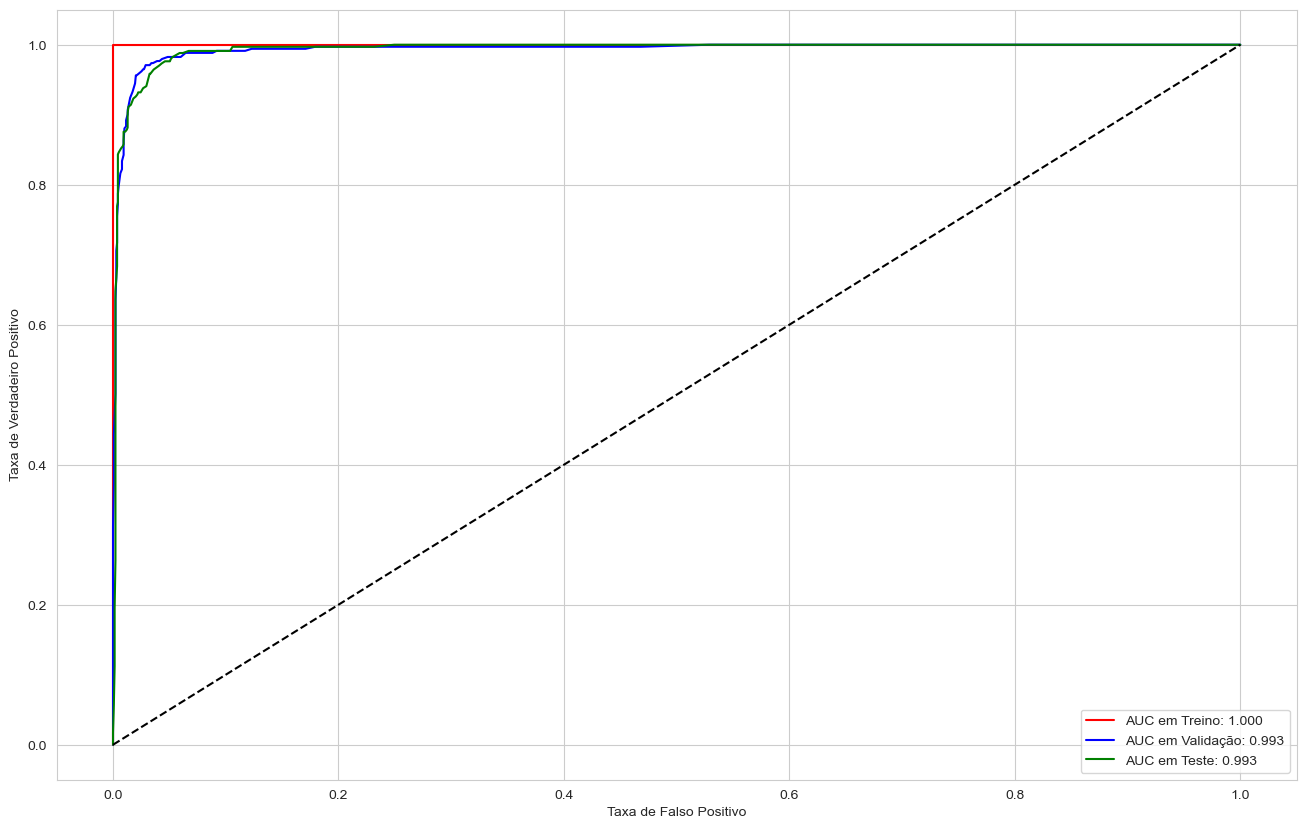

In [31]:
# Calcula a curva ROC nos dados de treino
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

# Calcula a curva ROC nos dados de validação
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

# Calcula a curva ROC nos dados de teste
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

# Plot
plt.figure(figsize=(16,10))
plt.plot(fpr_train, tpr_train, 'r-', label = 'AUC em Treino: %.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-', label = 'AUC em Validação: %.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-', label = 'AUC em Teste: %.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.legend()
plt.show()

## Deploy do Modelo

In [32]:
# Carregando dados de um novo cliente
novo_cliente = pd.read_csv('dados/novo_cliente.csv')

In [33]:
novo_cliente.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178
0,42,53,44,31,15,12,6,4,1,-4,...,-41,-16,2,22,33,45,56,67,69,63


In [34]:
novo_cliente_scaled = scaler.transform(novo_cliente)

In [35]:
novo_cliente_scaled

array([[ 0.23430103,  0.26330964,  0.21327887,  0.14547427,  0.06433421,
         0.04162138,  0.01245067,  0.00948678,  0.0004072 , -0.02089583,
        -0.05982225, -0.08823802, -0.09422636, -0.08206851, -0.05688321,
        -0.04513061, -0.04888646, -0.05884649, -0.03954335, -0.0268048 ,
        -0.03954517, -0.01361066,  0.0141796 ,  0.02964142,  0.02434803,
         0.02553403,  0.05046526,  0.07622867,  0.10625282,  0.10435503,
         0.08770101,  0.03628219,  0.02035452,  0.00290372,  0.02560331,
         0.04788545,  0.0803539 ,  0.11439743,  0.1269662 ,  0.15967329,
         0.17008419,  0.18494295,  0.17441442,  0.19293274,  0.19279889,
         0.18807764,  0.17420266,  0.13057865,  0.07347198,  0.02760618,
         0.01334455, -0.04209115, -0.09817825, -0.14470692, -0.17500193,
        -0.19419077, -0.19392033, -0.18826305, -0.17409285, -0.13599362,
        -0.09777884, -0.06104059, -0.02889629, -0.05156025, -0.04717145,
        -0.04596022, -0.03446032,  0.01195965,  0.0

In [36]:
best_model.predict_proba(novo_cliente_scaled)

array([[1., 0.]])

In [37]:
best_model.predict(novo_cliente_scaled)

array([0])

De acordo com a previsão do modelo, esse cliente não vai fazer a renovação do seguro.

In [38]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [39]:
#%watermark -v -m

In [40]:
#%watermark --iversions

# Fim